In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pvlib
import datetime
import pprint
import os
from pathlib import Path


## Load the measured data

In [2]:
measured = pd.read_csv(os.path.join(os.path.join(Path().resolve(), 'Data','BARNirrad_measured.csv')), header = 1) # The field pyranometer data
srrl_weather = pd.read_csv(str(Path().resolve() / 'WeatherFiles' /  'PSM3_60T.csv'), header = 2) # Data from SRRL
# Create a Datetime variable and set it as the index
srrl_weather['date'] = srrl_weather[['Year','Month','Day']].astype(str).agg('-'.join, axis=1) # Couldn't think of a proper way to chain this process into a single command. If you think of something, please let me know
srrl_weather['Minute'] = 0
srrl_weather['time'] = srrl_weather[['Hour','Minute']].astype(str).agg(':'.join, axis=1)
srrl_weather['Datetime'] = pd.to_datetime(srrl_weather[['date','time']].agg(" ".join, axis=1))

srrl_weather.set_index('Datetime', inplace=True)
# Create a Datetime variable for the measured data using the existing 'TIMESTAMP' column.
measured['Datetime'] = pd.to_datetime(measured['TIMESTAMP'], format ='%m/%d/%Y %H:%M')
measured = measured.drop(["TIMESTAMP", "RECORD"], axis = 'columns') # drop this column so the resample command does not confuse TIMESTAMP and Datetime columns
measured = measured.set_index('Datetime').resample('60T', axis = 'index', label='right', closed='right').mean() # The "label" and the "closed" arguments are different from that of how the SRRL data was read-in (which was "right" for both arguments), but this somehow yields a better timing match.


C:\Users\sayala\AppData\Local\Temp\1\ipykernel_8060\1714325002.py:13: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  measured = measured.set_index('Datetime').resample('60T', axis = 'index', label='right', closed='right').mean() # The "label" and the "closed" arguments are different from that of how the SRRL data was read-in (which was "right" for both arguments), but this somehow yields a better timing match.
C:\Users\sayala\AppData\Local\Temp\1\ipykernel_8060\1714325002.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  measured = measured.set_index('Datetime').resample('60T', axis = 'index', label='right', closed='right').mean() # The "label" and the "closed" arguments are different from that of how the SRRL data was read-in (which was "right" for both arguments), but this somehow yields a better timing match.


In [3]:
df = pd.concat([measured, srrl_weather],axis=1, join="inner")

## Finding calibration for AP_4

In [4]:
days = [g for n, g in df.groupby(pd.Grouper(freq='D'))]

plt.rcParams['figure.figsize'] = (12, 3)

val = []
for i in range (0, len(days)):
    data3 = days[i]
    if data3.GHI.max() >0:
        val.append(round(data3.Ap_4.max()/data3.GHI.max(),3))

In [5]:
val2 = [x for x in val if x > 1]
import statistics

correction_factor = statistics.mean(val2)

df['Ap_4_cal'] = df.Ap_4/correction_factor
print("Applied correction factor to Sensor 4 of ", correction_factor)

Applied correction factor to Sensor 4 of  1.08175


In [6]:
plt.rcParams['figure.figsize'] = (5, 3)

In [ ]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (5, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_4, 'r', label='Sensor 4')
    plt.plot(data3.index,data3.Ap_4_cal, 'b', label='Sensor 4 calibrated')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


In [ ]:
# Plot for Poster
fig, axs = plt.subplots(1,1)
data3 = weeks[i]
# Access each subplot using axs array

plt.ylabel('Ground_POA')
plt.plot(data3.index,data3.Ap_4, 'r', label='Sensor 4')
plt.plot(data3.index,data3.Ap_4_cal, 'b', label='Sensor 4 calibrated')
plt.xticks(rotation = 45)plt.xticks(rotation = 45)
axs.twinx()
axs.plot(data3.index,data3.GHI, '--k', label='GHI')
 
plt.title('Week'+str(i))
plt.ylabel('GHI')
plt.show()

In [ ]:
# Visualization of All Sensors
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_1, 'r', label='Sensor1')
    plt.plot(data3.index,data3.S1, 'g', label='Sensor2')
    plt.plot(data3.index,data3.S5, 'b', label='Sensor3')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


## Adding bifacial_radiance results

In [7]:
br = pd.read_csv('bifacial_radiance_BARN_GroundSensors_COMPILED_RESULTS_07Dec24_sorted.csv', header = 0) # The field pyranometer data

In [8]:
# Convert the 'day' column to a datetime object (assuming format like '9/1/2023')
br['day'] = pd.to_datetime(br['day'], format='%m/%d/%Y')

# Create a new 'timestamp' column by combining the 'day' and 'csv_name' (hour)
# Assuming 'csv_name' is the hour as a string (e.g., '09')
br['timestamp'] = br['day'].astype(str) + ' ' + br['hour'].astype(str) + ':00:00'
br['timestamp'] = pd.to_datetime(br['timestamp'])

# Set the 'timestamp' column as the DataFrame index
br.set_index('timestamp', inplace=True)

In [16]:
br.mattype.unique()

array(['groundplane'], dtype=object)

In [15]:
br2 = br.pivot_table(index='timestamp', columns='sensor', values='Wm2Front')
br2

sensor,1,2,3,4,5
timestamp,,,,,
2023-09-01 06:00:00,7.031,7.489,7.432,7.226,7.003
2023-09-01 07:00:00,17.241,20.723,20.031,17.747,16.072
2023-09-01 08:00:00,30.322,32.953,26.647,20.421,339.070
2023-09-01 09:00:00,551.784,556.783,39.307,27.544,27.244
2023-09-01 10:00:00,709.401,724.438,714.196,31.231,23.688
...,...,...,...,...,...
2023-10-31 13:00:00,25.248,610.248,620.822,620.024,30.431
2023-10-31 14:00:00,21.685,27.792,532.976,540.751,527.448
2023-10-31 15:00:00,387.841,22.133,28.873,37.193,399.159


In [22]:
br2.columns = [f"br_{col}" for col in br2.columns]

In [24]:
df2 = pd.concat([measured, srrl_weather, br2],axis=1, join="inner")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


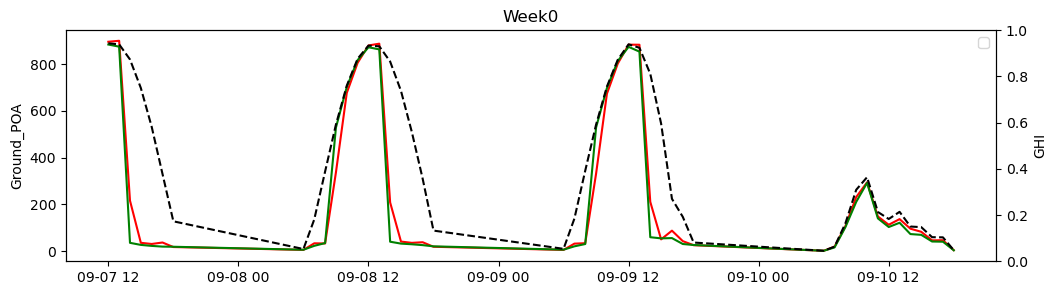

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


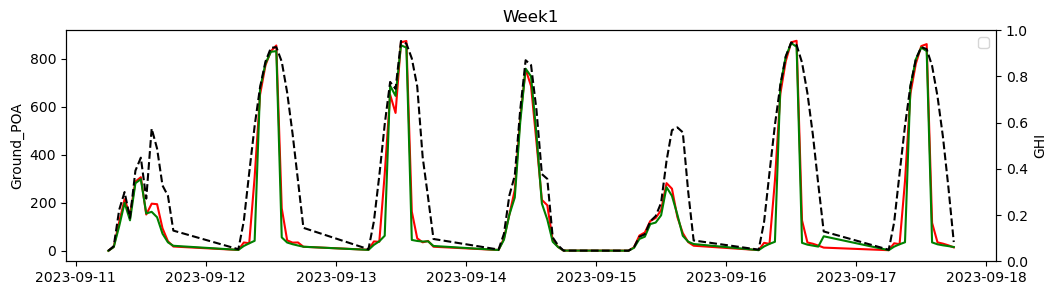

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


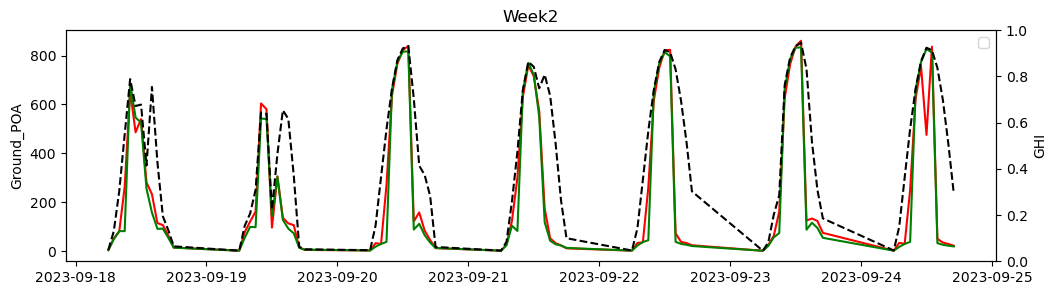

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


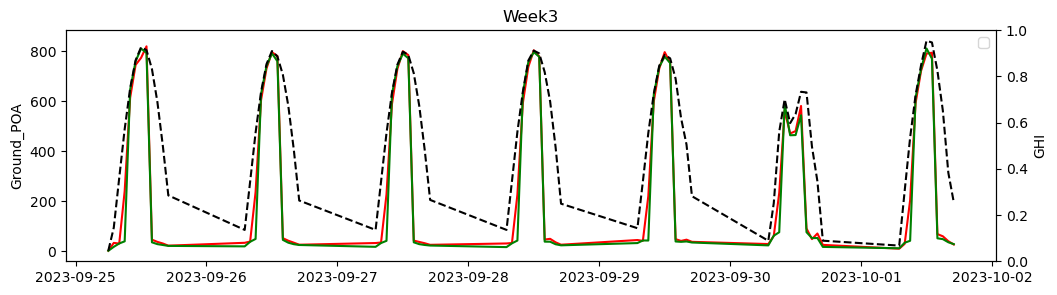

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


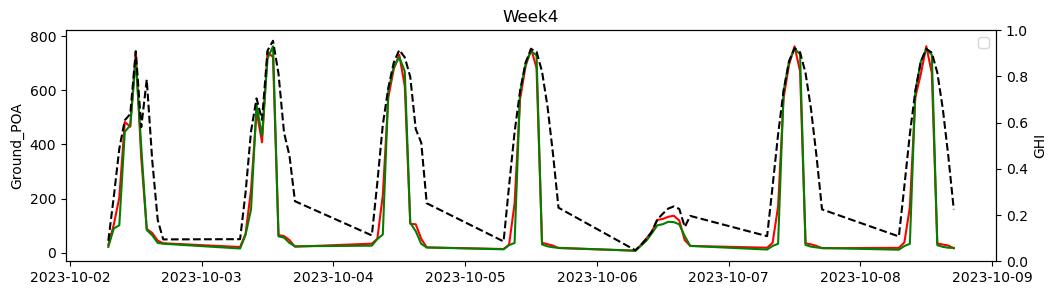

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


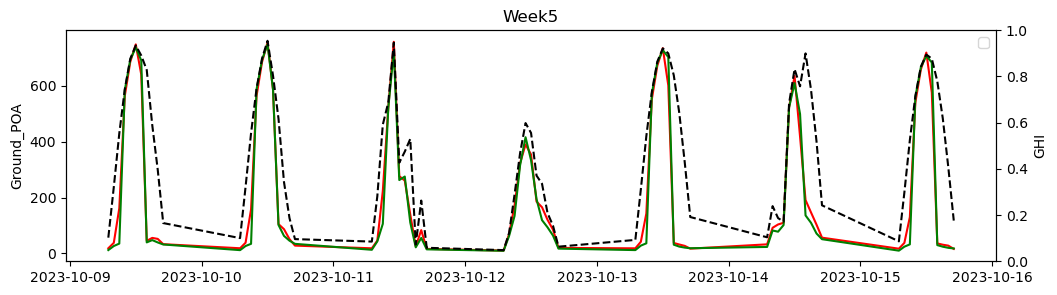

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


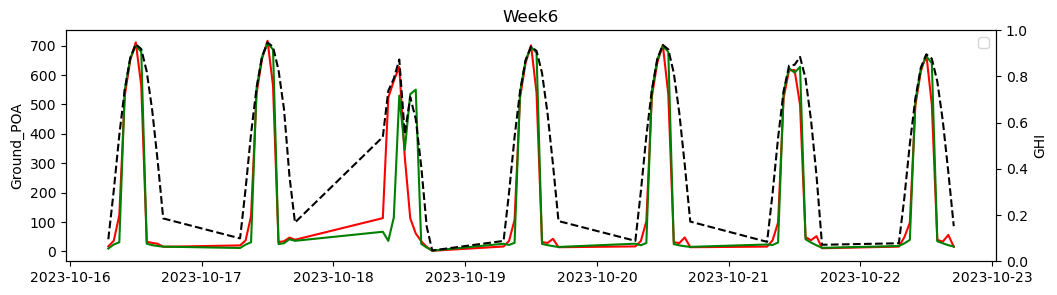

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


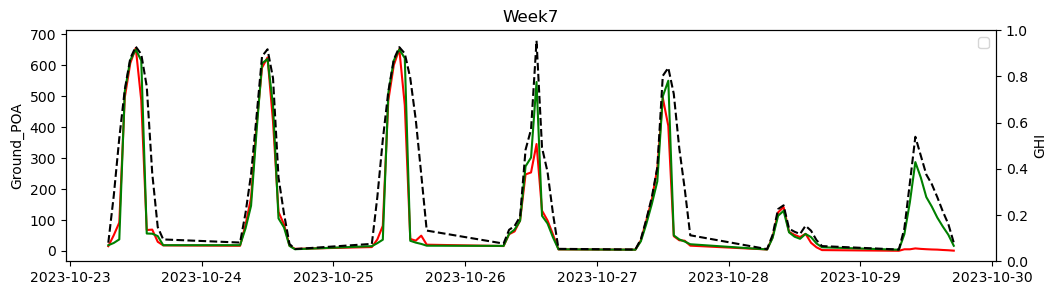

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


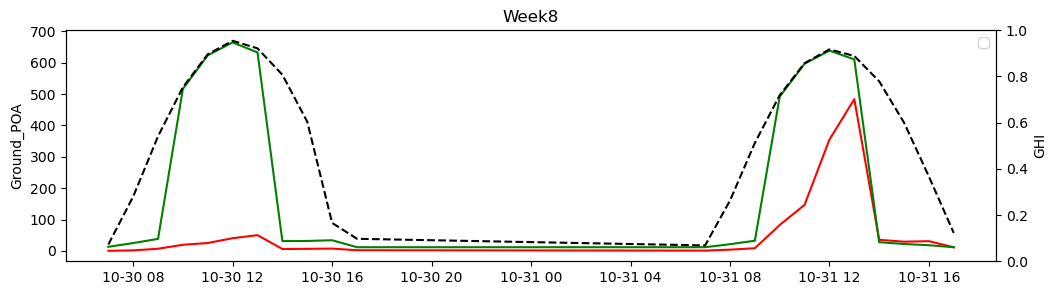

In [26]:
# Visualization Sensor BR vs measured
weeks = [g for n, g in df2.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_2, 'r', label='Sensor1')
    plt.plot(data3.index,data3.br_2, 'g', label='Sensor2')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


## Clean messy measured data

In [32]:
df2_clean = df2[df2.index.date != pd.to_datetime('2023-10-25').date()]
df2_clean = df2_clean[df2_clean.index.date != pd.to_datetime('2023-10-18').date()]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


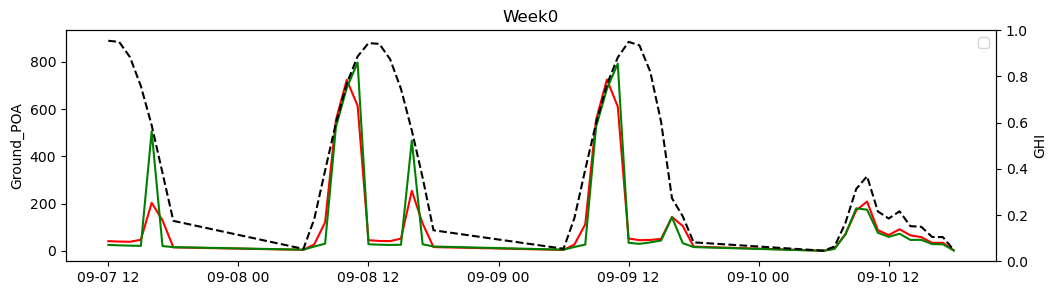

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


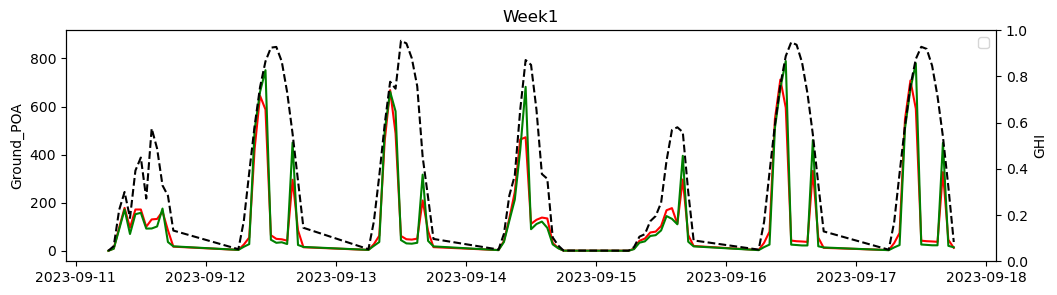

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


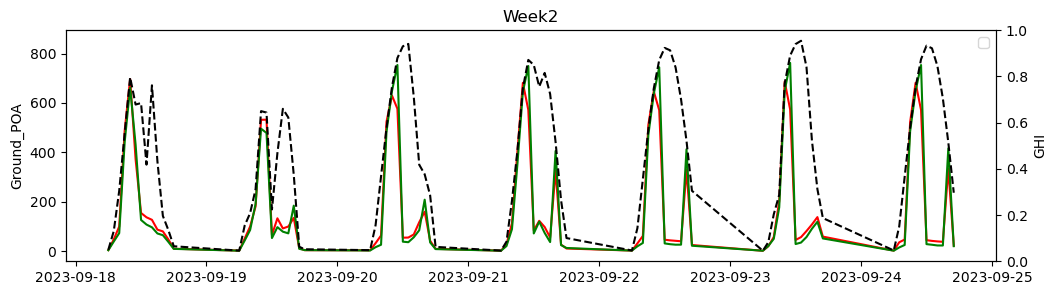

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


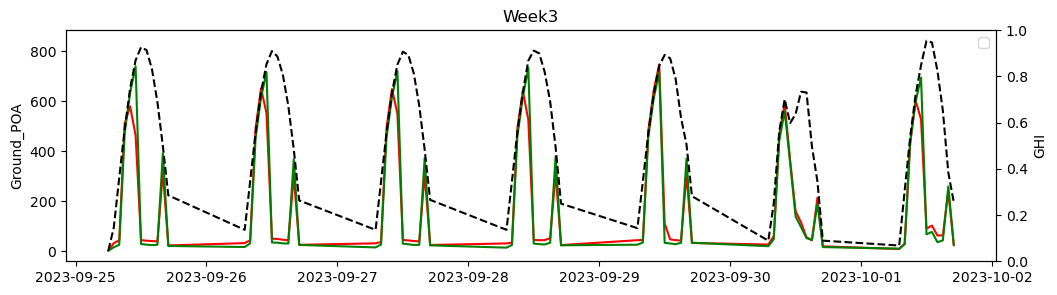

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


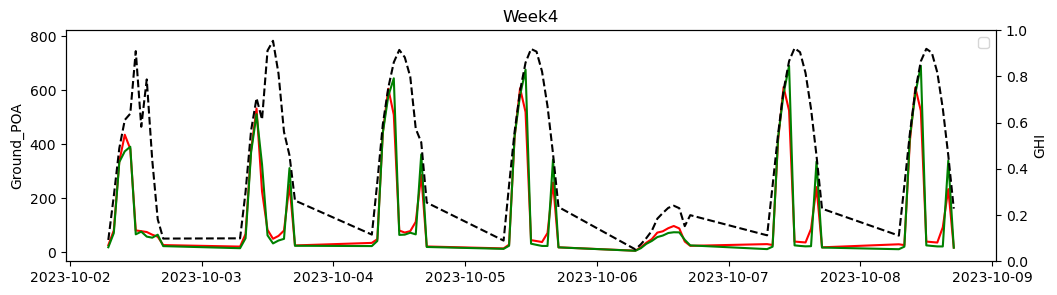

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


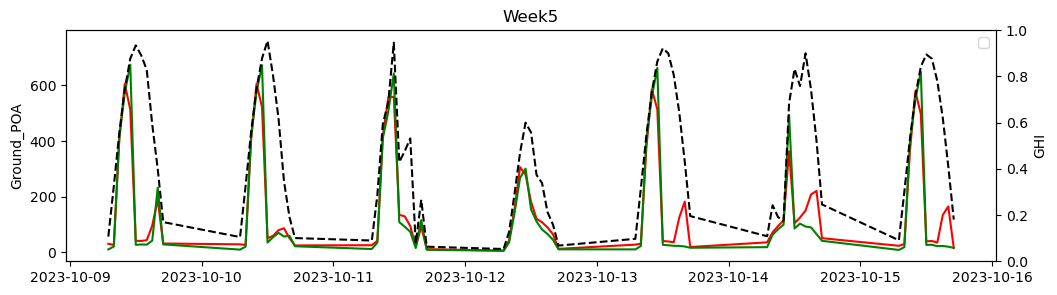

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


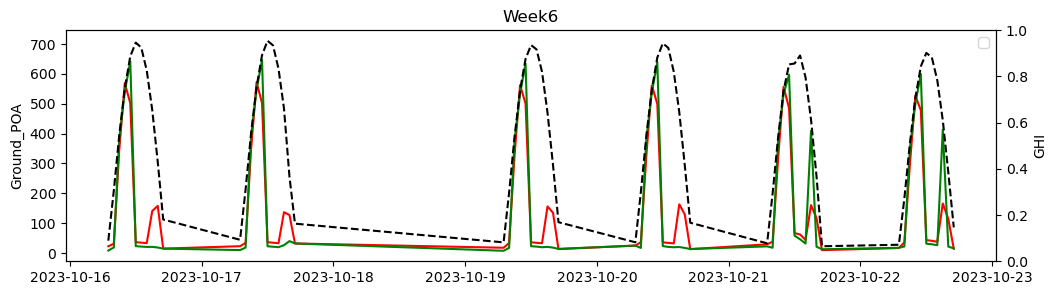

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


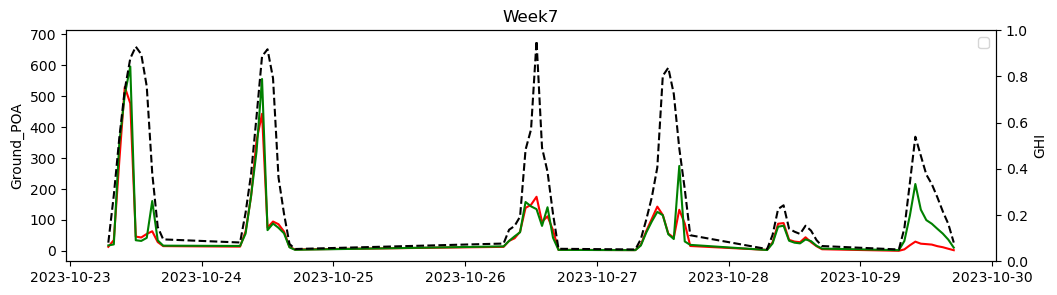

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


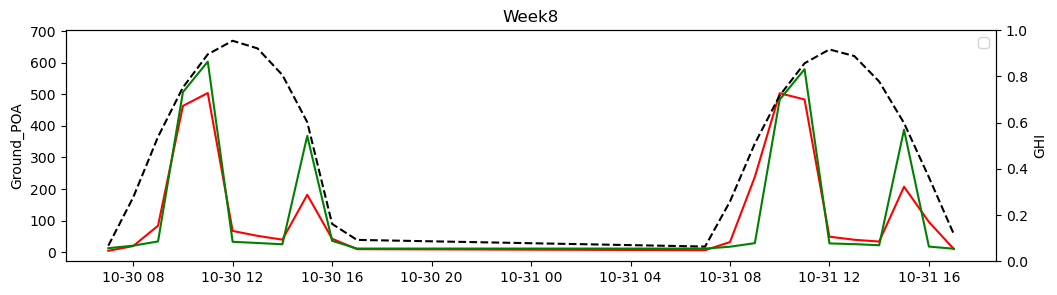

In [34]:
# See measured vs sensors without messy data
weeks = [g for n, g in df2_clean.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_1, 'r', label='Sensor1')
    plt.plot(data3.index,data3.br_1, 'g', label='Sensor2')

    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.legend()    
    plt.ylabel('GHI')
    plt.show()


## Adding view factor results

In [43]:
vF = pd.read_csv('bifacialvF_sensors_specific.csv', header = 0) # The field pyranometer data
vF = vF.set_index(pd.to_datetime(vF['date']))
vF.index = vF.index.tz_localize(None)
vF = vF.add_prefix("vf_")
df = pd.concat([df2_clean, vF],axis=1, join="inner")
len(df)

604

In [44]:
vF.keys()

Index(['vf_date', 'vf_S1', 'vf_S2', 'vf_S3', 'vf_S4', 'vf_S5', 'vf_sazm'], dtype='object')

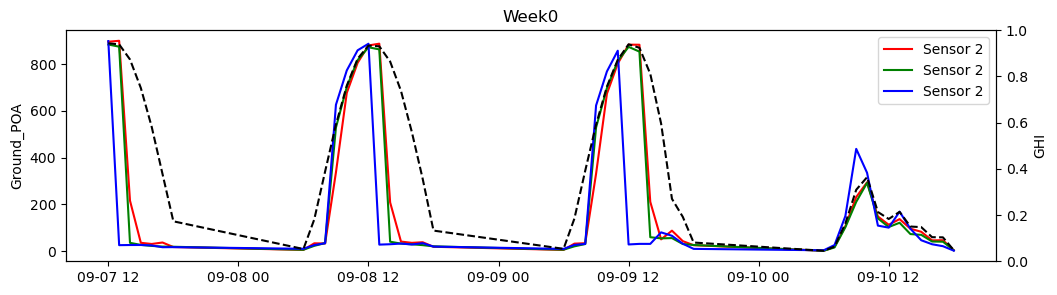

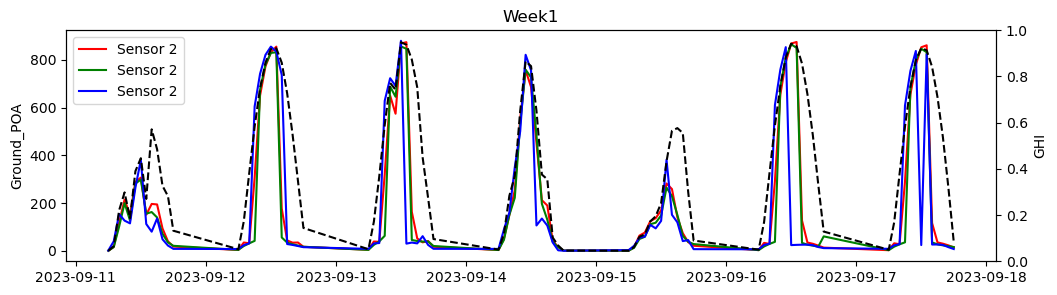

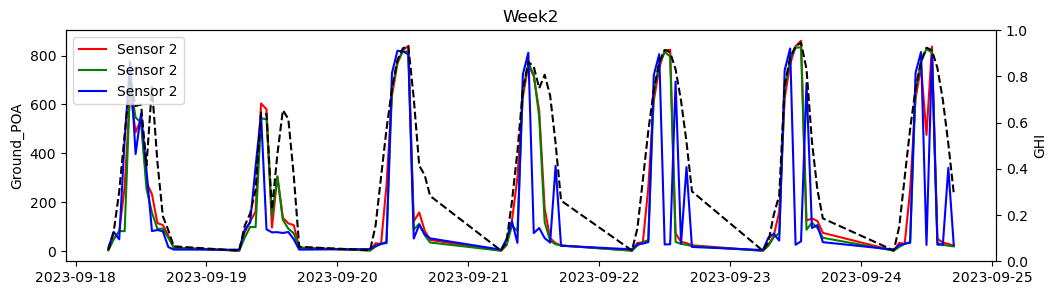

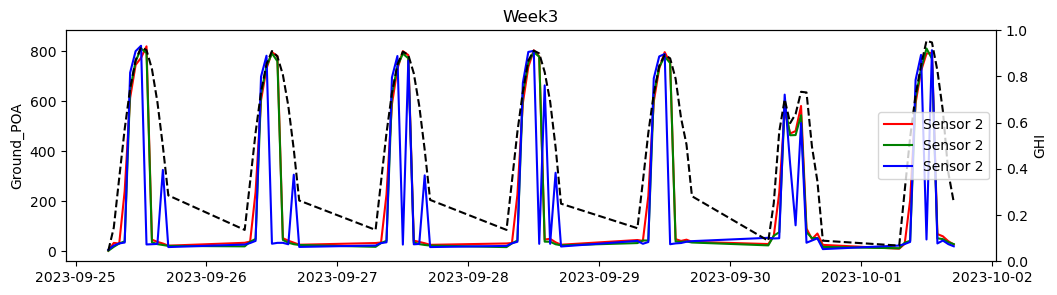

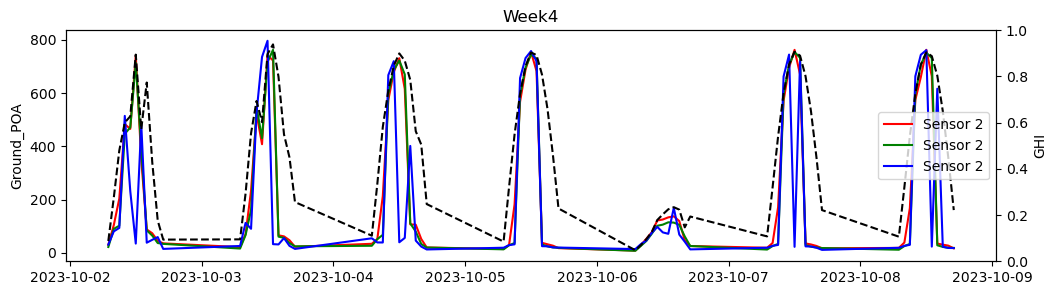

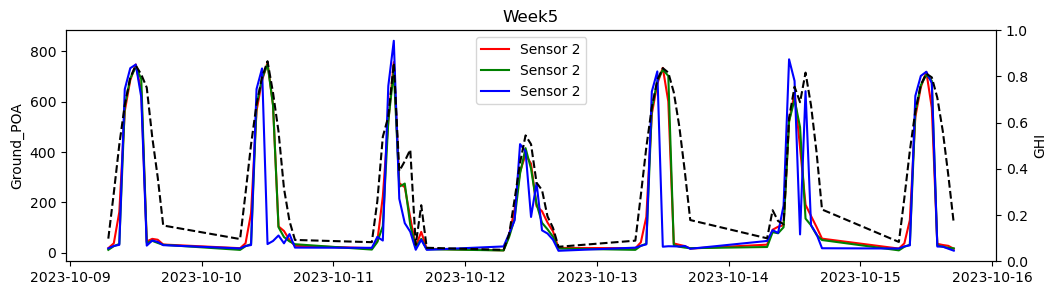

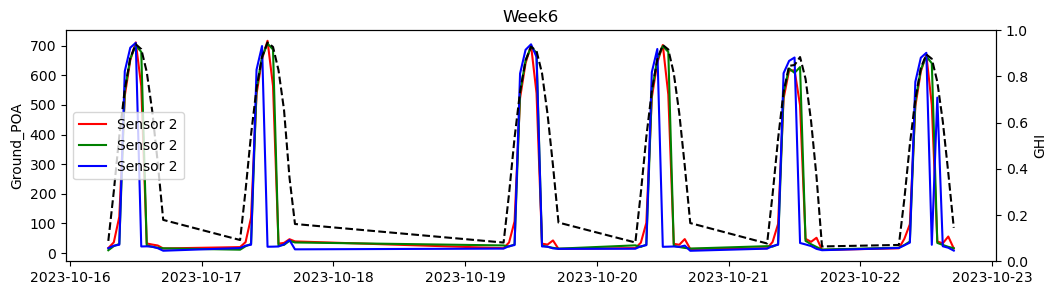

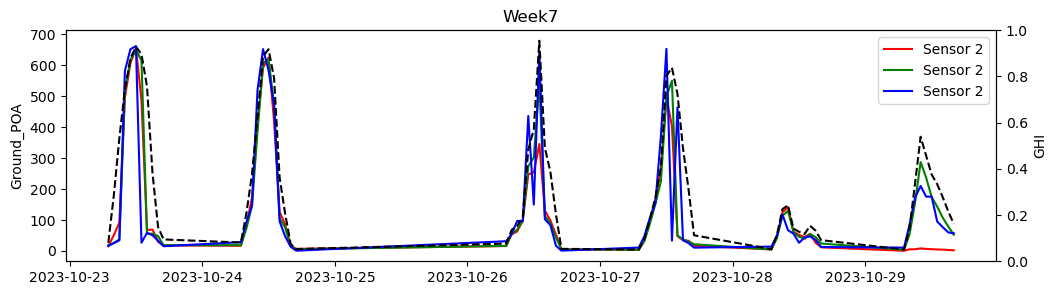

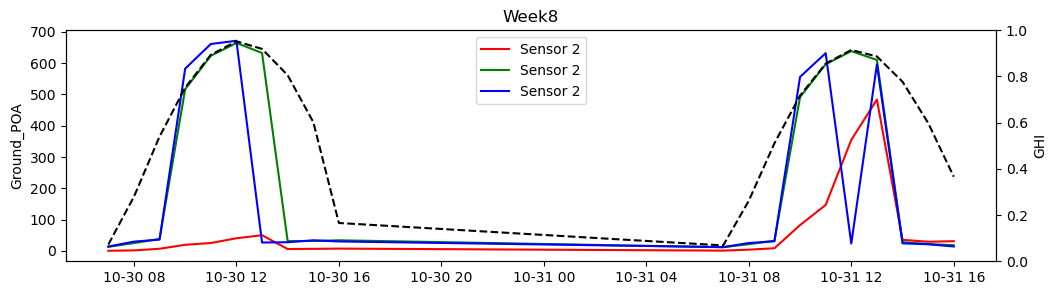

In [46]:
weeks = [g for n, g in df.groupby(pd.Grouper(freq='W'))]

plt.rcParams['figure.figsize'] = (12, 3)

for i in range (0, len(weeks)):
    fig, axs = plt.subplots(1,1)
    data3 = weeks[i]
    # Access each subplot using axs array
  
    plt.ylabel('Ground_POA')
    plt.plot(data3.index,data3.Ap_2, 'r', label='Sensor 2')
    plt.plot(data3.index,data3.br_2, 'g', label='Sensor 2')
    plt.plot(data3.index,data3.vf_S4, 'b', label='Sensor 2')
    plt.legend()    


    axs.twinx()
    axs.plot(data3.index,data3.GHI, '--k', label='GHI')
    plt.xticks(rotation = 45) 
    plt.title('Week'+str(i))
    plt.ylabel('GHI')
    plt.show()


## RMSE, MBD Analysis

In [51]:
# look at residuals (MBD, RMSE) based on Grear, Gpoa and Gtotal_modeled. From B. Marion Solar Energy 2016
def MBD(meas,model):
    # MBD=100∙[((1⁄(m)∙∑〖(y_i-x_i)]÷[(1⁄(m)∙∑〖x_i]〗)〗)
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    # rudimentary filtering of modeled irradiance
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = 100*((1/m)*sum(df.model-df.meas))/df.meas.mean()
    return out

def RMSE(meas,model):
    #RMSD=100∙〖[(1⁄(m)∙∑▒(y_i-x_i )^2 )]〗^(1⁄2)÷[(1⁄(m)∙∑▒〖x_i]〗)
    import numpy as np
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = 100*np.sqrt(1/m*sum((df.model-df.meas)**2))/df.meas.mean()
    return out

# residuals absolute output (not %) 
def MBD_abs(meas,model):
    # MBD=100∙[((1⁄(m)∙∑〖(y_i-x_i)]÷[(1⁄(m)∙∑〖x_i]〗)〗)
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    # rudimentary filtering of modeled irradiance
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = ((1/m)*sum(df.model-df.meas))
    return out

def RMSE_abs(meas,model):
    #RMSD=100∙〖[(1⁄(m)∙∑▒(y_i-x_i )^2 )]〗^(1⁄2)÷[(1⁄(m)∙∑▒〖x_i]〗)
    import numpy as np
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = np.sqrt(1/m*sum((df.model-df.meas)**2))
    return out

In [49]:
df.keys()

Index(['Ap_1', 'Ap_2', 'Ap_3', 'Ap_4', 'Ap_5', 'ST_con', 'ST_pv_bp',
       'ST_pv_is', 'PAR_con', 'PAR_pv', 'Batt_Volt', 'PTemp_C', 'Year',
       'Month', 'Day', 'Hour', 'Wspd', 'Tdry', 'DHI', 'DNI', 'GHI', 'Albedo',
       'date', 'Minute', 'time', 'br_1', 'br_2', 'br_3', 'br_4', 'br_5',
       'vf_date', 'vf_S1', 'vf_S2', 'vf_S3', 'vf_S4', 'vf_S5', 'vf_sazm'],
      dtype='object')

In [54]:
# Create the empty arrays (or lists? I don't know all the object types in python) to save the result of the looped error analysis
MBD_result_br = []
RMSE_result_br = []
MBD_abs_br = []
RMSE_abs_br = []

MBD_result_vf = []
RMSE_result_vf = []
MBD_abs_vf = []
RMSE_abs_vf = []


# For-looping the error analyses
for ii in range (1, 6): # The index range was determined after looking at the 
    MBD_result_br.append(MBD(df['Ap_'+str(ii)], df['br_'+str(ii)]))
    RMSE_result_br.append(RMSE(df['Ap_'+str(ii)], df['br_'+str(ii)]))
    MBD_abs_br.append(MBD_abs(df['Ap_'+str(ii)], df['br_'+str(ii)]))
    RMSE_abs_br.append(RMSE_abs(df['Ap_'+str(ii)], df['br_'+str(ii)]))

    MBD_result_vf.append(MBD(df['Ap_'+str(ii)], df['vf_S'+str(ii)]))
    RMSE_result_vf.append(RMSE(df['Ap_'+str(ii)], df['vf_S'+str(ii)]))
    MBD_abs_vf.append(MBD_abs(df['Ap_'+str(ii)], df['vf_S'+str(ii)]))
    RMSE_abs_vf.append(RMSE_abs(df['Ap_'+str(ii)], df['vf_S'+str(ii)]))

# Join the arrays into a dataframe
validationdf = pd.DataFrame(list(zip(MBD_result_br, RMSE_result_br, MBD_abs_br, RMSE_abs_br, 
                                     MBD_result_vf, RMSE_result_vf, MBD_abs_vf, RMSE_abs_vf,
                                     )), 
                                     columns = ['MBD_br', 'RMSE_br', 'MBD_abs_br', 'RMSE_abs_br',
                                                'MBD_vf', 'RMSE_vf', 'MBD_abs_vf', 'RMSE_abs_vf',
                                               ])    

# Export the result into a csv
validationdf.to_csv('Full_Datasets_RMSE_MBE.csv',index=False)
print(validationdf)

      MBD_br    RMSE_br  MBD_abs_br  RMSE_abs_br     MBD_vf     RMSE_vf  \
0   1.099116  37.005146    1.763572    59.376114  58.328898  196.516817   
1  -0.631459  33.200189   -1.483356    77.990277 -40.294952  136.110869   
2  -3.448452  28.822480   -9.514586    79.523794 -29.754204   74.045312   
3 -12.508364  23.981653  -31.807306    60.982538 -20.363675  151.949840   
4 -11.296243  40.083154  -18.700599    66.356488  78.831143  189.961849   

   MBD_abs_vf  RMSE_abs_vf  
0   93.590855   315.318441  
1  -94.656522   319.736866  
2  -82.094503   204.297620  
3  -51.782445   386.390668  
4  130.502650   314.476281  


## RMS and MBD but daily values


In [55]:
daily_df = df.resample('D').sum()

In [56]:
# Create the empty arrays (or lists? I don't know all the object types in python) to save the result of the looped error analysis
MBD_result_br = []
RMSE_result_br = []
MBD_abs_br = []
RMSE_abs_br = []

MBD_result_vf = []
RMSE_result_vf = []
MBD_abs_vf = []
RMSE_abs_vf = []


# For-looping the error analyses
for ii in range (1, 6): # The index range was determined after looking at the 
    MBD_result_br.append(MBD(daily_df['Ap_'+str(ii)], daily_df['br_'+str(ii)]))
    RMSE_result_br.append(RMSE(daily_df['Ap_'+str(ii)], daily_df['br_'+str(ii)]))
    MBD_abs_br.append(MBD_abs(daily_df['Ap_'+str(ii)], daily_df['br_'+str(ii)]))
    RMSE_abs_br.append(RMSE_abs(daily_df['Ap_'+str(ii)], daily_df['br_'+str(ii)]))

    MBD_result_vf.append(MBD(daily_df['Ap_'+str(ii)], daily_df['vf_S'+str(ii)]))
    RMSE_result_vf.append(RMSE(daily_df['Ap_'+str(ii)], daily_df['vf_S'+str(ii)]))
    MBD_abs_vf.append(MBD_abs(daily_df['Ap_'+str(ii)], daily_df['vf_S'+str(ii)]))
    RMSE_abs_vf.append(RMSE_abs(daily_df['Ap_'+str(ii)], daily_df['vf_S'+str(ii)]))

# Join the arrays into a dataframe
validationdf = pd.DataFrame(list(zip(MBD_result_br, RMSE_result_br, MBD_abs_br, RMSE_abs_br, 
                                     MBD_result_vf, RMSE_result_vf, MBD_abs_vf, RMSE_abs_vf,
                                     )), 
                                     columns = ['MBD_br', 'RMSE_br', 'MBD_abs_br', 'RMSE_abs_br',
                                                'MBD_vf', 'RMSE_vf', 'MBD_abs_vf', 'RMSE_abs_vf',
                                               ])    

# Export the result into a csv
validationdf.to_csv('Full_Datasets_RMSE_MBE.csv',index=False)
print(validationdf)

      MBD_br    RMSE_br  MBD_abs_br  RMSE_abs_br     MBD_vf    RMSE_vf  \
0   1.099116   9.130179   20.098069   166.951383  58.328898  68.212759   
1  -0.631459  16.887468  -16.904661   452.090635 -40.294952  50.339351   
2  -3.448452  10.674205 -108.430375   335.631224 -29.754204  34.468577   
3 -12.508364  15.501092 -362.483255   449.210354 -20.363675  31.602855   
4 -11.296243  14.811208 -213.116260   279.430012  78.831143  87.242952   

    MBD_abs_vf  RMSE_abs_vf  
0  1066.582579  1247.315549  
1 -1078.727161  1347.623542  
2  -935.567539  1083.802527  
3  -590.124464   915.827685  
4  1487.237750  1645.935923  


In [61]:
daily_df.keys()

Index(['Ap_1', 'Ap_2', 'Ap_3', 'Ap_4', 'Ap_5', 'ST_con', 'ST_pv_bp',
       'ST_pv_is', 'PAR_con', 'PAR_pv', 'Batt_Volt', 'PTemp_C', 'Year',
       'Month', 'Day', 'Hour', 'Wspd', 'Tdry', 'DHI', 'DNI', 'GHI', 'Albedo',
       'date', 'Minute', 'time', 'br_1', 'br_2', 'br_3', 'br_4', 'br_5',
       'vf_date', 'vf_S1', 'vf_S2', 'vf_S3', 'vf_S4', 'vf_S5', 'vf_sazm'],
      dtype='object')

<Axes: >

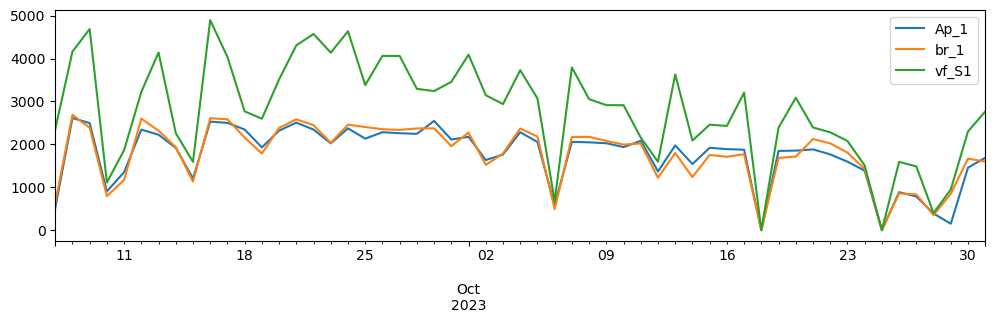

In [62]:
daily_df[['Ap_1','br_1','vf_S1']].plot()

<Axes: >

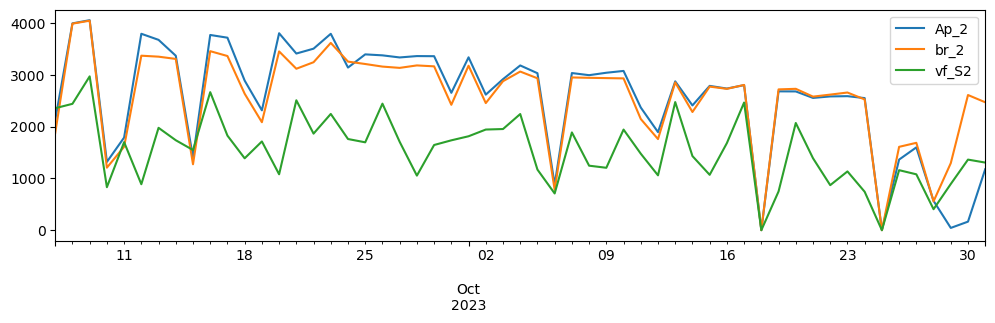

In [63]:
daily_df[['Ap_2','br_2','vf_S2']].plot()

<Axes: >

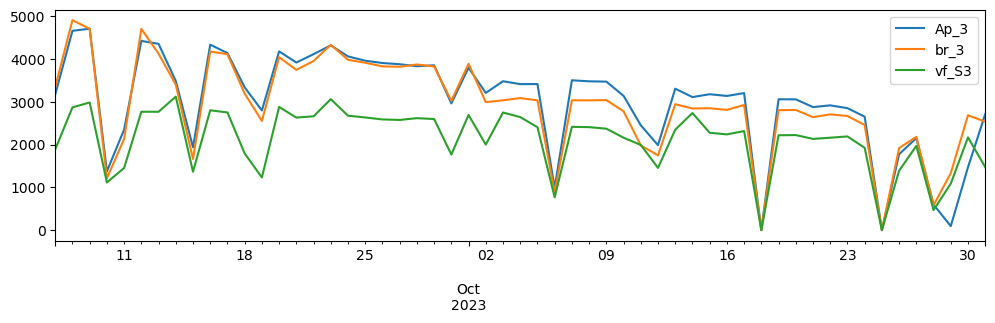

In [64]:
daily_df[['Ap_3','br_3','vf_S3']].plot()

<Axes: >

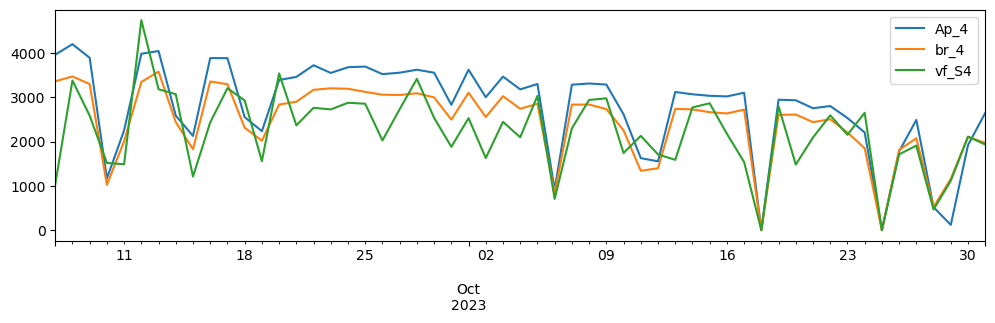

In [65]:
daily_df[['Ap_4','br_4','vf_S4']].plot()

<Axes: >

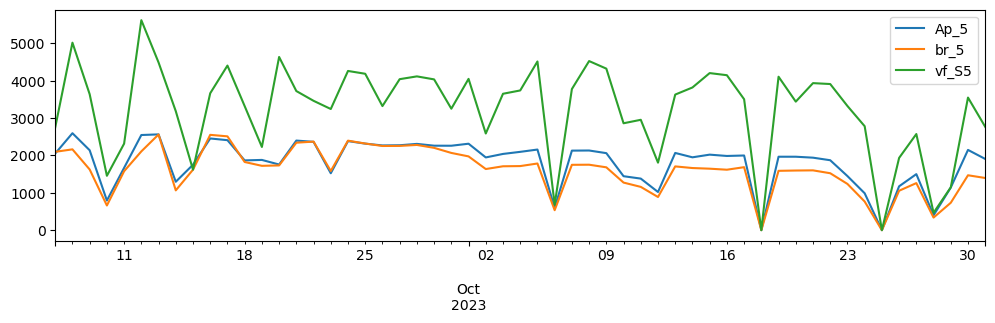

In [66]:
daily_df[['Ap_5','br_5','vf_S5']].plot()

## SMARTS Section

Do not run unnless necessary, takes forever

In [ ]:
from scipy import integrate
import pySMARTS

In [ ]:
pySMARTS.__version__

In [ ]:
df['spec_dni']=''
df['spec_dhi']=''
df['spec_ghi']=''
df['PAR_SMARTS'] = ''
df['SMARTS_DNI'] = ''
df['SMARTS_DHI'] = ''
df['SMARTS_GHI'] = ''

In [ ]:
#spec_dni = []
#spec_dhi = []
#spec_ghi = []

IOUT = '2 3 4' 
YEAR = '2023'
    
for ii in range (0, len(df)):
    if df.iloc[ii].GHI > 100: 
        MONTH = str(df.iloc[ii].Month).zfill(2)
        DAY = str(df.iloc[ii].Day).zfill(2)
        HOUR = str(df.iloc[ii].Hour).zfill(2)
        LATIT = '39.7407'
        LONGIT = '-105.1686'
        ALTIT = '1.730' # km above sea level
        ZONE = '-7' # Timezone
        spectra = pySMARTS.SMARTSTimeLocation(IOUT=IOUT,YEAR=YEAR,MONTH=MONTH,DAY=DAY,HOUR=HOUR, LATIT=LATIT, LONGIT=LONGIT, ALTIT=ALTIT, ZONE=ZONE)
        df['spec_dni'].iloc[ii]= list(spectra.Direct_normal_irradiance)
        df['spec_dhi'].iloc[ii]= list(spectra.Difuse_horizn_irradiance)
        df['spec_ghi'].iloc[ii]= list(spectra.Global_horizn_irradiance)
        df['PAR_SMARTS'].iloc[ii] = np.round(spectra.loc[240:540].Global_horizn_irradiance.sum(),3)
        df['SMARTS_DNI'].iloc[ii] = integrate.trapezoid(spectra.Direct_normal_irradiance, x=spectra.Wvlgth)
        df['SMARTS_DHI'].iloc[ii] = integrate.trapezoid(spectra.Difuse_horizn_irradiance, x=spectra.Wvlgth)
        df['SMARTS_GHI'].iloc[ii] = integrate.trapezoid(spectra.Global_horizn_irradiance, x=spectra.Wvlgth)

df.to_csv('Intermediate_results.csv')

In [ ]:
# Example code for just a day
startdate = '2021-09-07 7:0:0'
enddate = '2021-03-03 18:0:0'
foo = df[(df.index>startdate) & (df.index<enddate)]
plt.figure()
plt.plot(foo.index, foo.pvlib_Gfront, 'k', label='PVLIB')

In [ ]:
# look at residuals (MBD, RMSE) based on Grear, Gpoa and Gtotal_modeled. From B. Marion Solar Energy 2016
def MBD(meas,model):
    # MBD=100∙[((1⁄(m)∙∑〖(y_i-x_i)]÷[(1⁄(m)∙∑〖x_i]〗)〗)
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    # rudimentary filtering of modeled irradiance
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = 100*((1/m)*sum(df.model-df.meas))/df.meas.mean()
    return out

def RMSE(meas,model):
    #RMSD=100∙〖[(1⁄(m)∙∑▒(y_i-x_i )^2 )]〗^(1⁄2)÷[(1⁄(m)∙∑▒〖x_i]〗)
    import numpy as np
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = 100*np.sqrt(1/m*sum((df.model-df.meas)**2))/df.meas.mean()
    return out

# residuals absolute output (not %) 
def MBD_abs(meas,model):
    # MBD=100∙[((1⁄(m)∙∑〖(y_i-x_i)]÷[(1⁄(m)∙∑〖x_i]〗)〗)
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    # rudimentary filtering of modeled irradiance
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = ((1/m)*sum(df.model-df.meas))
    return out

def RMSE_abs(meas,model):
    #RMSD=100∙〖[(1⁄(m)∙∑▒(y_i-x_i )^2 )]〗^(1⁄2)÷[(1⁄(m)∙∑▒〖x_i]〗)
    import numpy as np
    import pandas as pd
    df = pd.DataFrame({'model':model,'meas':meas})
    df = df.dropna()
    minirr = meas.min()
    df = df[df.model>minirr]
    m = df.__len__()
    out = np.sqrt(1/m*sum((df.model-df.meas)**2))
    return out

In [ ]:
# Create the empty arrays (or lists? I don't know all the object types in python) to save the result of the looped error analysis
MBD_result = []
RMSE_result = []
MBD_abs_result = []
RMSE_abs_result = []
faillist = []

# Grab the list of column names
colnames = list(modeledandmeasured_suffix.columns.values)
modposition = []
measposition = []

# Setting the index to 0 prior to running the for-loop
i = 0

# For-looping the error analyses
for i in range (0, 5): # The index range was determined after looking at the 
    try:
        MBD_result.append(MBD(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]])) # The modeled columns and the measured counterparts are five columns apart, hence "i" and "i+5"
        RMSE_result.append(RMSE(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]]))
        MBD_abs_result.append(MBD_abs(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]]))
        RMSE_abs_result.append(RMSE_abs(modeledandmeasured_suffix[colnames[i+5]], modeledandmeasured_suffix[colnames[i]]))

        modposition.append(colnames[i])
        measposition.append(colnames[i+5])
    except:
        print(" FAILED ", i, colnames[i])
        faillist.append(colnames[i])

# Join the arrays into a dataframe
validationdf = pd.DataFrame(list(zip(modposition, measposition, MBD_result, RMSE_result, MBD_abs_result, RMSE_abs_result)), columns = ['Modeled', 'Measured', 'MBD', 'RMSE', 'MBD_abs', 'RMSE_abs'])    

# Export the result into a csv
validationdf.to_csv('out6.csv',index=False)

In [47]:
PAR_label = "Measured photoactive radiation (umol m<sup>-2</sup> s<sup>-1</sup>)"